In [1]:
library(ggplot2)
library(qvalue)
library(ComplexHeatmap)
library(circlize)

Loading required package: grid
ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

circlize version 0.4.9
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))



In [2]:
Giordanos_selection = "/hps/nobackup/stegle/users/galvari/data/iPSCs/singleCell/metadata/ensembl_gene/Ensembl_75_Gene_CV_quant5.txt"
G_file = read.csv(Giordanos_selection, sep = "\t")
nrow(G_file)
head(G_file,2)

[1] 21592

,gene,mean,std,CV,quartile_cv
2,ENSG00000227232,3.1805905,3.6232403,1.139172,2
3,ENSG00000243485,0.2003178,0.8649483,4.317881,3


In [3]:
##### Mean

In [4]:
mean_folder = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/SingleCell/PseudoBulk/mean/"

In [5]:
#### Chromosome 2

In [6]:
my_folder = paste0(mean_folder,"Run_Output_PCA5_88_log_TPM_scater_libsize_206/") # scran, 5PCs
df0 = read.csv(paste0(my_folder,"top_qtl_results_all.txt"), sep = "\t")
chr2_genes = unique(df0$feature_id)
length(chr2_genes)

[1] 50425

In [36]:
number_of_covs = c(5,10,15,20,25)

In [37]:
## PCs
PC_suffix = paste0("Run_Output_PCA",number_of_covs,"_88_log_TPM_scater_libsize_206/")
## PEER
PEER_suffix = paste0("Run_Output_PEER",number_of_covs,"_88_log_TPM_scater_libsize_206/")
## MOFA sparse
MOFA_suffix = paste0("Run_Output_MOFA",number_of_covs,"_88_log_TPM_scater_libsize_206/")
## MOFA non-sparse
MOFA_ns_suffix = paste0("Run_Output_MOFA",number_of_covs,"_88_log_TPM_scater_libsize_206_nonsparse/")
## linear scVI (LDVAE)
LDVAE_suffix = paste0("Run_Output_LDVAE",number_of_covs,"_88_log_TPM_scater_libsize_206/")

In [38]:
# number_of_covs = c(5,10,15,20)
# ## MOFA sparse
# MOFA_suffix = paste0("Run_Output_MOFA",number_of_covs,"_88_log_TPM_scater_libsize_206/")

In [39]:
suffixes = c(PC_suffix, PEER_suffix, MOFA_suffix, MOFA_ns_suffix, LDVAE_suffix)
length(suffixes)

[1] 25

In [40]:
filenames = paste0(mean_folder, suffixes, "top_qtl_results_all.txt")

In [41]:
df = data.frame()

In [42]:
for (file in filenames){
    df0 = read.csv(file, sep = "\t")
    df0 = df0[df0$feature_id %in% chr2_genes,]
#     df1 = df0
    df1 = df0[df0$feature_id %in% G_file$gene,]
    df1$q_value = qvalue(df1$empirical_feature_p_value)$qvalues
    n_genes = length(unique(df1$feature_id))
    n_eGenes = length(unique(df1[df1$q_value < 0.05,"feature_id"]))
    df = rbind(df, data.frame(n_genes = n_genes, n_eGenes = n_eGenes))    
}

In [44]:
df$method = c("PCA","PCA","PCA","PCA","PCA",
             "PEER","PEER","PEER","PEER","PEER",
             "MOFA","MOFA","MOFA","MOFA","MOFA",
             "MOFA-ns","MOFA-ns","MOFA-ns","MOFA-ns","MOFA-ns",
             "LDVAE","LDVAE","LDVAE","LDVAE","LDVAE")

In [45]:
nrow(df)

[1] 25

In [46]:
df$n_covs = c(number_of_covs,number_of_covs,number_of_covs,number_of_covs,number_of_covs)

In [47]:
head(df,2)

n_genes,n_eGenes,method,n_covs
20545,1746,PCA,5
20545,2005,PCA,10


In [48]:
## add results with no covariates
# my_folder = paste0(mean_folder,"Run_Output_NoFactor_88_log_TPM_scater_libsize_206_correct/") 
my_folder = paste0(mean_folder,"Run_Output_NoFactor_88_log_TPM_scater_libsize_206/") 
file = paste0(my_folder,"top_qtl_results_all.txt")

In [49]:
df0 = read.csv(file, sep = "\t")
df0 = df0[df0$feature_id %in% chr2_genes,]
#     df1 = df0
df1 = df0[df0$feature_id %in% G_file$gene,]
df1$q_value = qvalue(df1$empirical_feature_p_value)$qvalues
n_genes = length(unique(df1$feature_id))
n_eGenes = length(unique(df1[df1$q_value < 0.05,"feature_id"]))
df_0 = data.frame(n_genes = n_genes, n_eGenes = n_eGenes, n_covs = 0, 
                  method = c("PCA","PEER","MOFA","MOFA-ns","LDVAE"))
df_0

n_genes,n_eGenes,n_covs,method
20545,1120,0,PCA
20545,1120,0,PEER
20545,1120,0,MOFA
20545,1120,0,MOFA-ns
20545,1120,0,LDVAE


In [50]:
df_to_plot = rbind(df, df_0)

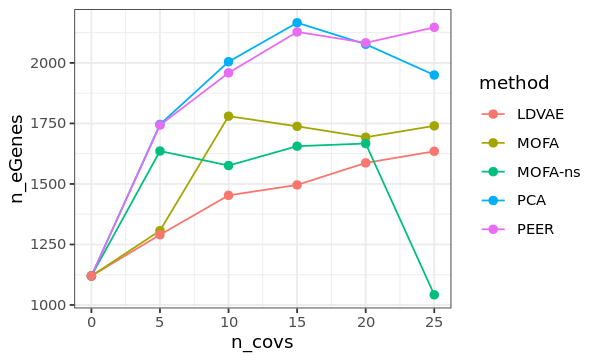

In [51]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(df_to_plot, aes(x = n_covs, y = n_eGenes, colour = method)) + geom_line() + geom_point(size=2) + theme_bw()

In [52]:
df_to_plot[df_to_plot$method == "MOFA",]

,n_genes,n_eGenes,method,n_covs
11,20545,1307,MOFA,5
12,20545,1780,MOFA,10
13,20545,1738,MOFA,15
14,20545,1693,MOFA,20
15,20545,1740,MOFA,25
28,20545,1120,MOFA,0


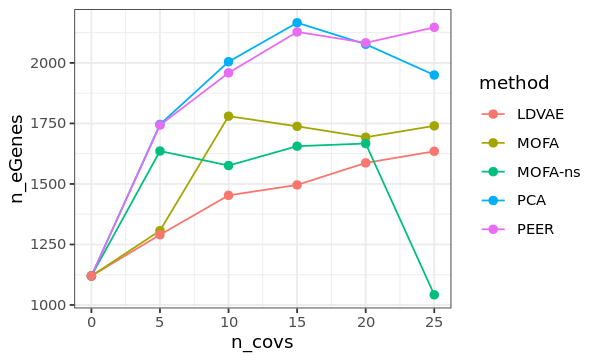

In [53]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(df_to_plot, aes(x = n_covs, y = n_eGenes, colour = method)) + geom_line() + geom_point(size=2) + theme_bw()

In [54]:
write.csv(df_to_plot, "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_eqtl/covariate_table_eGenes_all_chromosomes.csv")

In [25]:
l = list()
# i = 1

In [26]:
for (file in filenames){
    df0 = read.csv(file, sep = "\t")
    df0 = df0[df0$feature_id %in% chr2_genes,]
#     df1 = df0
    df1 = df0[df0$feature_id %in% G_file$gene,]
    df1$q_value = qvalue(df1$empirical_feature_p_value)$qvalues
    eGenes = unique(df1[df1$q_value < 0.05,"feature_id"])
    l[[file]] = as.character(eGenes)
#     i = i+1
}

In [27]:
mat = matrix(0, nrow = length(filenames), ncol = length(filenames))

In [28]:
i = 0
for (file1 in filenames){
    i = i+1
    j = 0
    for (file2 in filenames){
        j = j+1
        if (j<i){next}
        egenes1 = l[[file1]]
        egenes2 = l[[file2]]
        mat[i,j] = max(length(egenes1[egenes1 %in% egenes2])/length(egenes1), 
                       length(egenes1[egenes1 %in% egenes2])/length(egenes2))
        mat[j,i] = mat[i,j]
    }
}

In [29]:
method = c("PCA","PCA","PCA","PCA","PCA",
             "PEER","PEER","PEER","PEER","PEER",
             "MOFA","MOFA","MOFA","MOFA","MOFA",
             "MOFA-ns","MOFA-ns","MOFA-ns","MOFA-ns","MOFA-ns",
             "LDVAE","LDVAE","LDVAE","LDVAE","LDVAE")
n_covs = c(number_of_covs,number_of_covs,number_of_covs,number_of_covs,number_of_covs)
names = paste0(method, "_", n_covs)
head(names)

[1] "PCA_5"  "PCA_10" "PCA_15" "PCA_20" "PCA_25" "PEER_5"

In [30]:
rownames(mat) = names
colnames(mat) = names
mat[1:5,1:5]

,PCA_5,PCA_10,PCA_15,PCA_20,PCA_25
PCA_5,1.00000,0.7000000,0.7375000,0.7062500,0.6625000
PCA_10,0.70000,1.0000000,0.7696970,0.7333333,0.7272727
PCA_15,0.73750,0.7696970,1.0000000,0.7828571,0.7964072
PCA_20,0.70625,0.7333333,0.7828571,1.0000000,0.8203593
PCA_25,0.66250,0.7272727,0.7964072,0.8203593,1.0000000


In [31]:
mat[grep("_5",rownames(mat)),grep("_5",colnames(mat))]
mean_5 = mean(mat[grep("_5",rownames(mat)),grep("_5",colnames(mat))])
mean_5

,PCA_5,PEER_5,MOFA_5,MOFA-ns_5,LDVAE_5
PCA_5,1.0000000,0.7094595,0.7131783,0.7225806,0.7433628
PEER_5,0.7094595,1.0000000,0.7054264,0.7027027,0.6902655
MOFA_5,0.7131783,0.7054264,1.0000000,0.7054264,0.6991150
MOFA-ns_5,0.7225806,0.7027027,0.7054264,1.0000000,0.7168142
LDVAE_5,0.7433628,0.6902655,0.6991150,0.7168142,1.0000000


[1] 0.7686665

In [32]:
mat[grep("_10",rownames(mat)),grep("_10",colnames(mat))]
mean_10 = mean(mat[grep("_10",rownames(mat)),grep("_10",colnames(mat))])
mean_10

,PCA_10,PEER_10,MOFA_10,MOFA-ns_10,LDVAE_10
PCA_10,1.0000000,0.7410072,0.7151515,0.7565789,0.7033898
PEER_10,0.7410072,1.0000000,0.7697842,0.7194245,0.7033898
MOFA_10,0.7151515,0.7697842,1.0000000,0.7500000,0.7288136
MOFA-ns_10,0.7565789,0.7194245,0.7500000,1.0000000,0.6779661
LDVAE_10,0.7033898,0.7033898,0.7288136,0.6779661,1.0000000


[1] 0.7812404

In [33]:
mat[grep("_15",rownames(mat)),grep("_15",colnames(mat))]
mean_15 = mean(mat[grep("_15",rownames(mat)),grep("_15",colnames(mat))])
mean_15

,PCA_15,PEER_15,MOFA_15,MOFA-ns_15,LDVAE_15
PCA_15,1.0000000,0.6986301,0.7134146,0.7046980,0.7333333
PEER_15,0.6986301,1.0000000,0.7260274,0.6849315,0.6222222
MOFA_15,0.7134146,0.7260274,1.0000000,0.7248322,0.7037037
MOFA-ns_15,0.7046980,0.6849315,0.7248322,1.0000000,0.6740741
LDVAE_15,0.7333333,0.6222222,0.7037037,0.6740741,1.0000000


[1] 0.7588694

In [34]:
mat[grep("_20",rownames(mat)),grep("_20",colnames(mat))]
mean_20 = mean(mat[grep("_20",rownames(mat)),grep("_20",colnames(mat))])
mean_20

,PCA_20,PEER_20,MOFA_20,MOFA-ns_20,LDVAE_20
PCA_20,1.0000000,0.7460317,0.7333333,0.7012987,0.7151899
PEER_20,0.7460317,1.0000000,0.7777778,0.7777778,0.6746032
MOFA_20,0.7333333,0.7777778,1.0000000,0.7402597,0.6835443
MOFA-ns_20,0.7012987,0.7777778,0.7402597,1.0000000,0.6883117
LDVAE_20,0.7151899,0.6746032,0.6835443,0.6883117,1.0000000


[1] 0.7790502

In [35]:
mat[grep("_25",rownames(mat)),grep("_25",colnames(mat))]
mean_25 = mean(mat[grep("_25",rownames(mat)),grep("_25",colnames(mat))])
mean_25

,PCA_25,PEER_25,MOFA_25,MOFA-ns_25,LDVAE_25
PCA_25,1.0000000,0.7604790,0.7012987,0.8214286,0.7291667
PEER_25,0.7604790,1.0000000,0.7597403,0.8750000,0.7013889
MOFA_25,0.7012987,0.7597403,1.0000000,0.8035714,0.6319444
MOFA-ns_25,0.8214286,0.8750000,0.8035714,1.0000000,0.6875000
LDVAE_25,0.7291667,0.7013889,0.6319444,0.6875000,1.0000000


[1] 0.7977214

In [36]:
mean(mean_5, mean_10, mean_15, mean_20, mean_25)

[1] 0.7686665

In [38]:
nrow(mat)
ncol(mat)

[1] 25

[1] 25

In [57]:
mat

,PCA_5,PCA_10,PCA_15,PCA_20,PCA_25,PEER_5,PEER_10,PEER_15,PEER_20,PEER_25,...,MOFA-ns_5,MOFA-ns_10,MOFA-ns_15,MOFA-ns_20,MOFA-ns_25,LDVAE_5,LDVAE_10,LDVAE_15,LDVAE_20,LDVAE_25
PCA_5,1.0000000,0.7000000,0.7375000,0.7062500,0.6625000,0.7094595,0.7338129,0.7534247,0.7777778,0.7375000,...,0.7225806,0.6907895,0.6778523,0.6948052,0.8035714,0.7433628,0.7457627,0.7407407,0.6202532,0.6527778
PCA_10,0.7000000,1.0000000,0.7696970,0.7333333,0.7272727,0.7229730,0.7410072,0.7260274,0.8253968,0.7939394,...,0.7225806,0.7565789,0.7181208,0.7467532,0.8571429,0.7699115,0.7033898,0.7481481,0.6835443,0.7222222
PCA_15,0.7375000,0.7696970,1.0000000,0.7828571,0.7964072,0.6824324,0.7338129,0.6986301,0.7698413,0.7540984,...,0.7483871,0.7434211,0.7046980,0.7402597,0.8482143,0.7522124,0.7457627,0.7333333,0.7278481,0.7500000
PCA_20,0.7062500,0.7333333,0.7828571,1.0000000,0.8203593,0.6756757,0.7194245,0.6712329,0.7460317,0.7657143,...,0.6903226,0.7105263,0.6845638,0.7012987,0.8482143,0.6902655,0.6949153,0.7333333,0.7151899,0.7152778
PCA_25,0.6625000,0.7272727,0.7964072,0.8203593,1.0000000,0.6351351,0.6978417,0.6301370,0.7142857,0.7604790,...,0.6838710,0.6644737,0.6510067,0.6818182,0.8214286,0.6725664,0.6864407,0.7037037,0.6835443,0.7291667
PEER_5,0.7094595,0.7229730,0.6824324,0.6756757,0.6351351,1.0000000,0.8129496,0.7876712,0.8412698,0.7162162,...,0.7027027,0.6891892,0.6554054,0.7229730,0.8214286,0.6902655,0.6864407,0.6296296,0.6216216,0.6111111
PEER_10,0.7338129,0.7410072,0.7338129,0.7194245,0.6978417,0.8129496,1.0000000,0.7769784,0.8412698,0.7482014,...,0.7482014,0.7194245,0.6618705,0.7266187,0.7767857,0.7079646,0.7033898,0.6296296,0.6474820,0.6187050
PEER_15,0.7534247,0.7260274,0.6986301,0.6712329,0.6301370,0.7876712,0.7769784,1.0000000,0.8253968,0.7260274,...,0.7465753,0.7328767,0.6849315,0.7534247,0.8214286,0.7168142,0.7033898,0.6222222,0.6095890,0.5902778
PEER_20,0.7777778,0.8253968,0.7698413,0.7460317,0.7142857,0.8412698,0.8412698,0.8253968,1.0000000,0.8015873,...,0.7857143,0.7698413,0.7142857,0.7777778,0.7767857,0.6902655,0.6610169,0.6190476,0.6746032,0.6428571
PEER_25,0.7375000,0.7939394,0.7540984,0.7657143,0.7604790,0.7162162,0.7482014,0.7260274,0.8015873,1.0000000,...,0.7612903,0.7368421,0.7248322,0.7467532,0.8750000,0.7345133,0.7542373,0.7407407,0.6962025,0.7013889


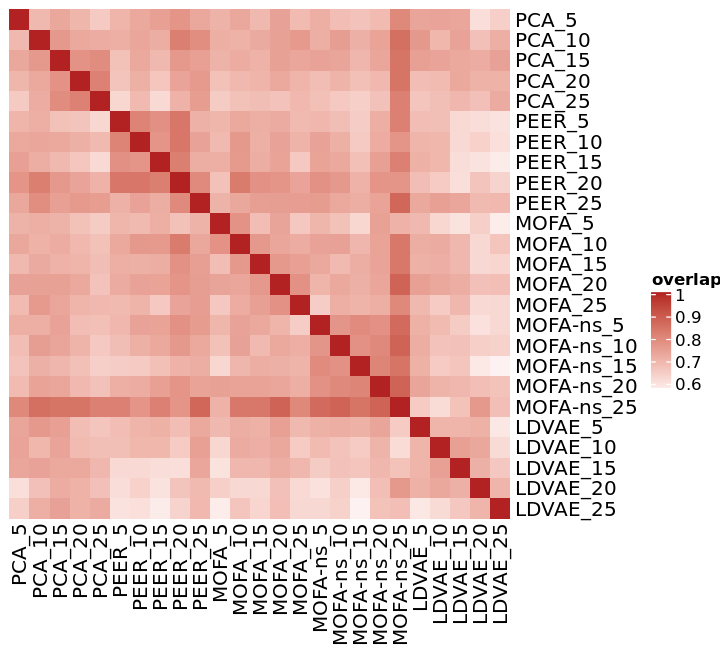

In [60]:
options(repr.plot.width = 6, repr.plot.height = 5.5)
Heatmap(mat, show_row_dend = F, show_column_dend = F, 
        name = "overlap", cluster_rows = F, cluster_columns = F,
        col = colorRamp2(c(0.55, 1), c("white", "firebrick")))